(ДЛЯ УДОБНОГО ПРОСМОТРА ДВОЙНОЙ КЛИК ПО ЯЧЕЙКЕ) 

В этом проекте попробую импортировать только двумерный набор данных ЗАРАБОТАЛО

c 2 и 3 параметрами всё ок
с 4 ломается уже на первом обучении
с 5 ломается при уточнении сетки
с 6 ломается сразу
с 7 ломается сразу
с 8 ломается на третьем уточнении сетки
с 9 ломается при уточнении сетки
с 10 ломается при уточнении сетки
с 11 ломается сразу
с 12 ломается при уточнении сетки
с 13 ломается после нескольких шагов первого обучения

Это при параметрах модели: model = KAN(width=[13,1,1], grid=grids[i], k=k, seed=1, device=device) 13- кол-во параметров в данном прогоне
grids = np.array([3,10,20,50,80])
steps = 20
k = 3  

In [95]:
from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [96]:
data = pd.read_csv('file_for_input/all_hour/SBER_tradestats_test_hour.csv')
data = data[['pr_open_hour','pr_close_hour','vol','val','trades','trades_b','trades_s', 'val_b', 'val_s','vol_b','vol_s', 'pr_high_hour','pr_low_hour']] # Не добавлются сюда другие лейблы
# ['vol','val','trades','trades_b','trades_s', 'val_b','val_s','vol_b','vol_s','pr_open_hour','pr_high_hour','pr_low_hour','pr_close_hour'] <- полный список параметров
data_lable= data [['pr_close_hour']]

data_tensor = torch.tensor(data.values, dtype=torch.float32)
data_tensor_lable=torch.tensor(data_lable.values, dtype=torch.float32)
print (data_tensor.shape)

torch.Size([8525, 13])


In [97]:
# Убедитесь, что device определен (проверить код в этой ячейке)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Создание датасета
dataset = create_dataset_from_data(data_tensor, data_tensor_lable, train_ratio=0.8, device=device)

# Проверка размеров датасета
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)


torch.Size([6820, 13])
torch.Size([6820, 1])
torch.Size([1705, 13])
torch.Size([1705, 1])


In [98]:
dataset['train_input']

tensor([[1.2572e+02, 1.2615e+02, 1.8372e+05,  ..., 6.5594e+04, 1.2625e+02,
         1.2555e+02],
        [3.3000e+02, 3.3145e+02, 4.1908e+05,  ..., 1.8359e+05, 3.3172e+02,
         3.2997e+02],
        [3.5998e+02, 3.6230e+02, 5.6332e+05,  ..., 2.0309e+05, 3.6232e+02,
         3.5920e+02],
        ...,
        [2.5761e+02, 2.5691e+02, 4.3734e+05,  ..., 2.5103e+05, 2.5779e+02,
         2.5633e+02],
        [1.2562e+02, 1.2608e+02, 4.1865e+05,  ..., 2.1750e+05, 1.2712e+02,
         1.2535e+02],
        [3.0903e+02, 3.0761e+02, 5.5602e+05,  ..., 3.2706e+05, 3.1088e+02,
         3.0761e+02]])

In [99]:
dataset['train_label']  

tensor([[126.1500],
        [331.4500],
        [362.3000],
        ...,
        [256.9100],
        [126.0800],
        [307.6100]])

In [100]:
dataset['train_input'].shape, dataset['train_label'].shape 

(torch.Size([6820, 13]), torch.Size([6820, 1]))

# initialize KAN with G=3


In [114]:
grids = np.array([3,10,20,50,80])

train_losses = []
test_losses = []
steps = 20
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[13,1,1], grid=grids[i], k=k, seed=1, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: 0.00e+00 | :   5%|▍        | 1/20 [00:11<03:31, 11.11s/it]


KeyboardInterrupt: 

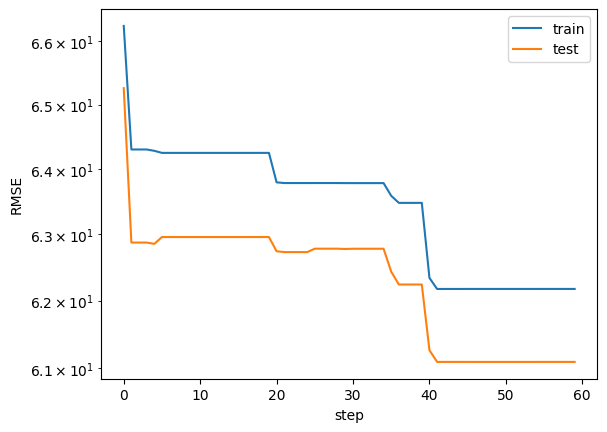

In [59]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Text(0, 0.5, 'RMSE')

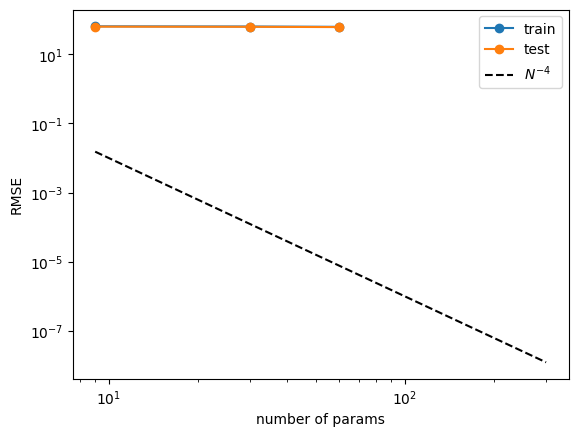

In [58]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')